# Traditional Logistic Regression Approach using StatsModels

## Project Context
This notebook represents the final stage of our systematic investigation into machine learning approaches for predicting fatigue in IBD patients. In previous notebooks (2-5), we progressed from traditional machine learning algorithms (scikit-learn) to deep neural networks (DNNs), with the notebooks structured to enable direct performance comparisons.

Our analysis has revealed that the DNN approach consistently outperforms the six other machine learning algorithms we tested. To validate this finding and establish a comprehensive benchmark, we now implement a traditional statistical logistic regression model using statsmodels.

This comparison is particularly important because while logistic regression appears in both statistical and machine learning contexts, the implementation approaches differ significantly. The traditional statistical approach used here provides population-level insights through formal hypothesis testing, while the DNN approach offers advantages in predictive accuracy and personalized predictions.

By comparing the DNN against this established statistical method, we can quantify the performance improvements and provide context for the added value of more advanced machine learning techniques in this clinical prediction task.

## Comparison of Traditional Logistic Regression vs. Machine Learning Logistic Regression

Traditional logistic regression, as implemented in libraries like `statsmodels`, is typically fitted using **Maximum Likelihood Estimation (MLE)**. The goal of MLE is to find the model parameters (coefficients) that maximize the probability (likelihood) of observing the actual outcome data given the predictor variables. This optimization problem is often solved using iterative numerical methods like **Iteratively Reweighted Least Squares (IRLS)** or **Newton-Raphson**, which utilize second-derivative information (the Hessian matrix) for faster convergence, especially on smaller datasets. The emphasis is often on statistical inference, providing detailed summaries with p-values, confidence intervals, and goodness-of-fit tests.

In contrast, the machine learning approach often fits logistic regression by minimizing a **cost function** (like log-loss or cross-entropy, which is equivalent to maximizing the likelihood) using optimization algorithms like **Gradient Descent** (or its variants like Stochastic Gradient Descent, Mini-batch Gradient Descent, Adam, etc.). Gradient Descent iteratively adjusts the model parameters in the direction opposite to the gradient of the cost function. It primarily uses first-derivative information (the gradient). This approach scales better to very large datasets where computing the Hessian matrix for IRLS/Newton's method can be computationally expensive. The focus in the machine learning context is typically more on predictive performance and generalization to unseen data, often incorporating regularization techniques (L1/L2) directly into the cost function to prevent overfitting.

**Traditional Statistical Approach (e.g., `statsmodels` using MLE/IRLS):**

*   **Rich Inference:** Provides detailed statistical summaries, including p-values, confidence intervals for coefficients (and odds ratios), standard errors, and goodness-of-fit measures. This is useful for understanding the significance and uncertainty associated with each predictor.
*   **Interpretability Focus:** Emphasizes interpreting model coefficients (often as odds ratios) and their statistical significance in the context of the data.
*   **Exact Solutions:** Optimization methods like IRLS often converge to the precise Maximum Likelihood Estimate.
*   **Efficiency on Smaller Data:** Can converge faster on smaller datasets due to using second-order information (Hessian matrix).

**Machine Learning Approach (e.g., `scikit-learn` using Gradient Descent):**

*   **Scalability:** Handles very large datasets (large number of samples or features) more efficiently as it avoids computationally expensive matrix inversions required by methods like Newton-Raphson.
*   **Regularization:** Easily incorporates L1 and L2 regularization to prevent overfitting and perform implicit feature selection, improving generalization to new data.
*   **Flexibility:** Variants like Stochastic Gradient Descent (SGD) allow for online learning (updating the model as new data arrives).
*   **Optimization Focus:** Primarily optimized for predictive performance on unseen data.
*   **Pipeline Integration:** Integrates smoothly into standard machine learning workflows involving preprocessing, cross-validation, and hyperparameter tuning.

In [1]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import pickle
import numpy as np
from sklearn.metrics import (
    roc_curve,
    roc_auc_score,
    accuracy_score,
    confusion_matrix,
    classification_report,
)

from src.data.preprocessing import (
    load_and_preprocess_data,
    remove_low_value_features,
    fix_numerical_features_for_production,
)
from sklearn.preprocessing import StandardScaler
from src.config.constants import NUMERICAL_FEATURES, RANDOM_SEED
from src.config.paths import BENCHMARKING_DIR, ensure_output_dirs
from src.data.splitting import split_data_for_sklearn
from src.visualization.plotting import plot_roc_curve

plt.rcParams["font.family"] = ["Roboto", "Arial", "sans-serif"]

ensure_output_dirs()

## Configuration

In [2]:
random_seed = RANDOM_SEED
output_path = BENCHMARKING_DIR

## Data Processing Pipeline

In [3]:
# Same data preprocessing pipeline as DNN
df = load_and_preprocess_data()
df = remove_low_value_features(df)
numerical_features = NUMERICAL_FEATURES
numerical_features = fix_numerical_features_for_production(numerical_features)

In [4]:
scaler = StandardScaler()
scaler.fit(df[numerical_features])
df[numerical_features] = scaler.transform(df[numerical_features])

In [5]:
# Use the sklearn split as we don't need to manually create validation sets
X_train, X_test, y_train, y_test, groups = split_data_for_sklearn(df)

## Create the Logistic Regression Model

In [6]:
# Add a constant (intercept) to the features matrix for statsmodels
X_train_sm = sm.add_constant(X_train)
X_test_sm = sm.add_constant(X_test)  # Also add to test set for prediction
logit_model = sm.Logit(y_train, X_train_sm)

# Fit the model
logit_result = logit_model.fit()

         Current function value: 0.491819
         Iterations: 35


/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


### Export the Model

In [7]:
save_path = BENCHMARKING_DIR / "statsmodels_logreg.pkl"
with open(save_path, "wb") as file:
    pickle.dump(logit_result, file)

## Model Evaluation

In [8]:
logit_result.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                                                  Results: Logit
===================================================================================================================
Model:                                Logit                            Method:                           MLE       
Dependent Variable:                   fatigue_outcome                  Pseudo R-squared:                 0.290     
Date:                                 2025-04-23 16:35                 AIC:                              1078.2591 
No. Observations:                     962                              BIC:                              1399.6141 
Df Model:                             65                               Log-Likelihood:                   -473.13   
Df Residuals:                         896                              LL-Null:                          -666.79   
Converged:                            0.0000                           LLR p-value:                      2.2244e-47
No. Iterations:                       35.0000                          Scale:                            1.0000    
-------------------------------------------------------------------------------------------------------------------
                                                           Coef.    Std.Err.     z    P>|z|     [0.025     0.975]  
-------------------------------------------------------------------------------------------------------------------
const                                                     -16.5248  1585.3812 -0.0104 0.9917  -3123.8148  3090.7651
age                                                         2.5299     1.5203  1.6641 0.0961     -0.4499     5.5097
sex                                                        -0.5907     0.2824 -2.0914 0.0365     -1.1443    -0.0371
height                                                     -0.0303     0.2128 -0.1424 0.8868     -0.4473     0.3867
weight                                                     -0.0946     0.2842 -0.3328 0.7393     -0.6516     0.4625
bmi                                                         0.7232     0.6199  1.1666 0.2434     -0.4919     1.9383
age_at_diagnosis                                           -2.3586     1.5079 -1.5642 0.1178     -5.3141     0.5968
montreal_upper_gi                                          -0.2062     0.5287 -0.3900 0.6965     -1.2424     0.8300
montreal_perianal                                           0.5327     0.3860  1.3802 0.1675     -0.2238     1.2892
has_active_symptoms                                         1.4957     0.2104  7.1092 0.0000      1.0833     1.9081
albumin                                                     0.1412     0.1239  1.1394 0.2545     -0.1017     0.3841
crp                                                         0.4902     0.1571  3.1214 0.0018      0.1824     0.7981
haemoglobin                                                -0.1963     0.1117 -1.7568 0.0790     -0.4153     0.0227
red_cell_count                                              0.0340     0.1022  0.3326 0.7394     -0.1663     0.2342
white_cell_count                                            0.0948     0.2404  0.3942 0.6934     -0.3765     0.5660
neutrophils                                                -0.0176     0.0809 -0.2179 0.8275     -0.1762     0.1409
lymphocytes                                                -0.0651     0.0993 -0.6555 0.5122     -0.2597     0.1295
monocytes                                                  -0.1265     0.5117 -0.2471 0.8048     -1.1294     0.8765
eosinophils                                                 0.0261     0.0955  0.2728 0.7850     -0.1612     0.2133
basophils                                                   0.0163     0.0938  0.1732 0.8625     -0.1677     0.2002
platelets                                                   0.4943     0.1051  4.7031 0.0000      0.2883     0.7004
urea                                                      

In [9]:
results_summary_df = logit_result.summary2().tables[1]
coef_df = results_summary_df.copy().reset_index()
coef_df = coef_df.rename(columns={"index": "Feature"})

# Calculate odds ratios and 95% CI for odds ratios
coef_df["Odds Ratio"] = np.exp(coef_df["Coef."])
coef_df["OR_Lower_CI"] = np.exp(coef_df["Coef."] - 1.96 * coef_df["Std.Err."])
coef_df["OR_Upper_CI"] = np.exp(coef_df["Coef."] + 1.96 * coef_df["Std.Err."])

# Sort by absolute coefficient value to see most important features
coef_df["Abs_Coef"] = coef_df["Coef."].abs()
coef_df_sorted = coef_df.sort_values("Abs_Coef", ascending=False)

# Display the top 15 most important features
print("Top 15 Most Important Features:")
print(
    coef_df_sorted.head(15)[
        ["Feature", "Coef.", "Odds Ratio", "P>|z|", "OR_Lower_CI", "OR_Upper_CI"]
    ]
)

# Identify statistically significant features (p < 0.05)
significant_features = coef_df[coef_df["P>|z|"] < 0.05].sort_values("P>|z|")
print(f"\nStatistically Significant Features (p < 0.05): {len(significant_features)}")
print(significant_features[["Feature", "Coef.", "Odds Ratio", "P>|z|"]])

Top 15 Most Important Features:
                   Feature      Coef.    Odds Ratio     P>|z|  OR_Lower_CI  \
40           sampling_risa  19.570406  3.157324e+08  0.999562     0.000000   
62           season_autumn  18.212739  8.122540e+07  0.990834     0.000000   
63           season_spring  17.956544  6.286775e+07  0.990963     0.000000   
65           season_winter  17.865272  5.738377e+07  0.991009     0.000000   
64           season_summer  17.582855  4.326504e+07  0.991151     0.000000   
0                    const -16.524836  6.658171e-08  0.991684     0.000000   
45     study_group_name_UC  -4.519709  1.089219e-02  0.005284     0.000455   
1                      age   2.529923  1.255254e+01  0.096100     0.637679   
6         age_at_diagnosis  -2.358639  9.454885e-02  0.117773     0.004922   
44   study_group_name_IBDU  -2.331957  9.710549e-02  0.220631     0.002326   
43     study_group_name_CD  -2.310834  9.917849e-02  0.160331     0.003939   
59     is_smoker_Ex-smoker   2.2

/Users/chershiongchuah/Developer/machine_learning_for_ibd_fatigue/venv/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


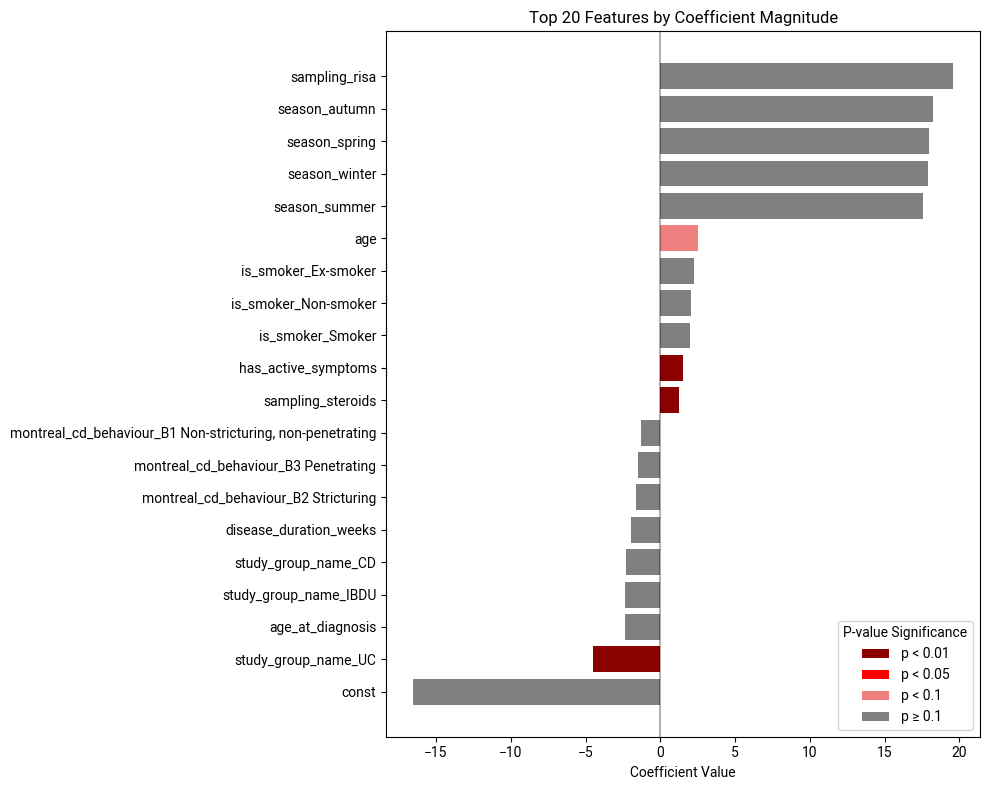

In [10]:
# Add this as a new cell following the code above

# Plot the top 15 features by coefficient magnitude
plt.figure(figsize=(10, 8))
top_features = coef_df_sorted.head(20).copy()
top_features = top_features.sort_values(
    "Coef."
)  # Sort by actual coefficient value for the plot

# Create color map based on p-values
colors = [
    "darkred"
    if p < 0.01
    else "red"
    if p < 0.05
    else "lightcoral"
    if p < 0.1
    else "gray"
    for p in top_features["P>|z|"]
]

bars = plt.barh(top_features["Feature"], top_features["Coef."], color=colors)
plt.axvline(x=0, color="black", linestyle="-", alpha=0.3)
plt.xlabel("Coefficient Value")
plt.title("Top 20 Features by Coefficient Magnitude")

# Create legend for p-value color coding
legend_elements = [
    Patch(facecolor="darkred", label="p < 0.01"),
    Patch(facecolor="red", label="p < 0.05"),
    Patch(facecolor="lightcoral", label="p < 0.1"),
    Patch(facecolor="gray", label="p ≥ 0.1"),
]
plt.legend(handles=legend_elements, title="P-value Significance", loc="lower right")
plt.tight_layout()
plt.show()

### Forest Plot 

Shows odds ratios, confidence intervals for significant features

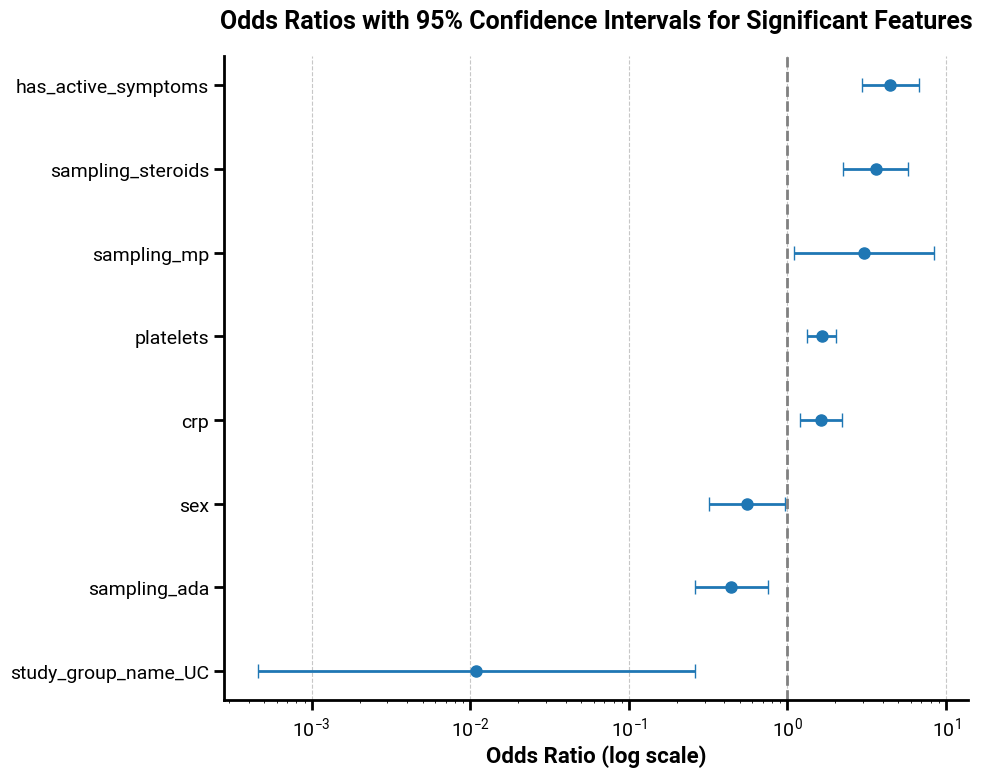

In [11]:
plt.figure(figsize=(10, 8))
sig_features = significant_features.sort_values("Odds Ratio")
if len(sig_features) > 0:
    # Set font sizes
    plt.rcParams.update(
        {
            "font.size": 14,
            "axes.labelsize": 16,
            "axes.titlesize": 18,
            "xtick.labelsize": 14,
            "ytick.labelsize": 14,
            "legend.fontsize": 14,
            "axes.linewidth": 2,
            "xtick.major.width": 2,
            "ytick.major.width": 2,
            "xtick.major.size": 7,
            "ytick.major.size": 7,
        }
    )

    # Create the error bar plot
    plt.errorbar(
        sig_features["Odds Ratio"],
        sig_features["Feature"],
        xerr=[
            sig_features["Odds Ratio"] - sig_features["OR_Lower_CI"],
            sig_features["OR_Upper_CI"] - sig_features["Odds Ratio"],
        ],
        fmt="o",
        capsize=5,
        markersize=8,
        elinewidth=2,
    )

    # Add reference line
    plt.axvline(
        x=1, color="grey", linestyle="--", linewidth=2, label="OR = 1 (No Effect)"
    )

    # Set log scale for x-axis
    plt.xscale("log")

    # Add labels and title
    plt.xlabel("Odds Ratio (log scale)", fontweight="bold")
    plt.title(
        "Odds Ratios with 95% Confidence Intervals for Significant Features",
        fontweight="bold",
        pad=20,
    )

    # Customize grid
    plt.grid(axis="x", linestyle="--", alpha=0.7)

    # Remove top and right spines
    plt.gca().spines["top"].set_visible(False)
    plt.gca().spines["right"].set_visible(False)

    # Adjust layout
    plt.tight_layout()
    plt.show()
else:
    print("No statistically significant features to plot.")

### Predictions and Classification on Test Set

In [12]:
y_pred_prob_sm = logit_result.predict(X_test_sm)
y_pred_classes = (y_pred_prob_sm > 0.5).astype(int)

### Calculate Metrics

In [13]:
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob_sm)
roc_auc = roc_auc_score(y_test, y_pred_prob_sm)
accuracy = accuracy_score(y_test, y_pred_classes)
tn, fp, fn, tp = confusion_matrix(y_test, y_pred_classes).ravel()
sensitivity = tp / (tp + fn)  # Recall
specificity = tn / (tn + fp)

print(f"Accuracy: {accuracy:.4f}")
print(f"Sensitivity (Recall): {sensitivity:.4f}")
print(f"Specificity: {specificity:.4f}")
print(f"AUC: {roc_auc:.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes))

# Create a metrics dictionary for potential export/comparison
metrics = {
    "accuracy": accuracy,
    "sensitivity": sensitivity,
    "specificity": specificity,
    "auc": roc_auc,
}

print(metrics)

Accuracy: 0.6206
Sensitivity (Recall): 0.5897
Specificity: 0.6471
AUC: 0.7085

Classification Report:
              precision    recall  f1-score   support

           0       0.65      0.65      0.65       136
           1       0.59      0.59      0.59       117

    accuracy                           0.62       253
   macro avg       0.62      0.62      0.62       253
weighted avg       0.62      0.62      0.62       253

{'accuracy': 0.6205533596837944, 'sensitivity': np.float64(0.5897435897435898), 'specificity': np.float64(0.6470588235294118), 'auc': np.float64(0.7085218702865762)}


### Plot ROC Curve

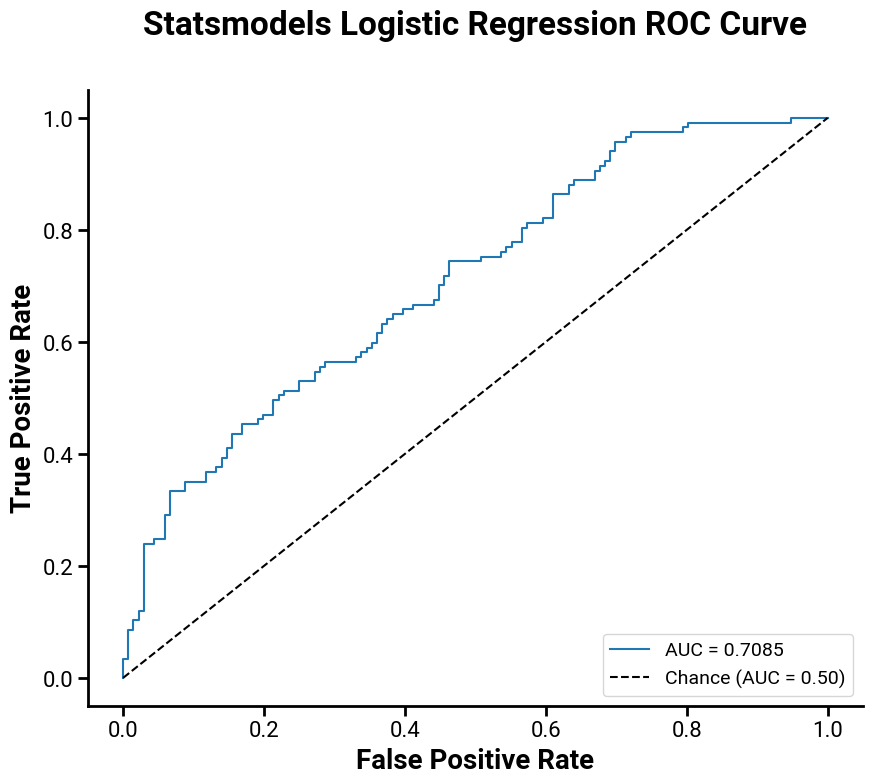

In [14]:
save_path = BENCHMARKING_DIR / "statsmodels_logreg_roc_curve.png"
plot_roc_curve(
    fpr=fpr,
    tpr=tpr,
    test_auc=roc_auc,
    output_path=save_path,
    title="Statsmodels Logistic Regression ROC Curve",
)